In [2]:
# importing packages
import pandas as pd
#from pandas_datareader import data as web
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# Loading in raw and making changes
stock_data_raw = pd.read_csv("adjprice.csv")

# If NaN, then either sub 0 or last non 0 price
filled_stock_data = stock_data_raw.ffill().bfill()
        
# If negative, take absolute value
# stocks = list(stock_data_raw.columns)
# for columns in stocks:
#     modify_data = stock_data_raw.loc[stock_data_raw[columns] <= 0]
# modify_data


# If value too large/small, linearly interpolate 
# Finding potential outliers
pct_data_max = filled_stock_data.pct_change().max().tolist()
outliers = []
for values in pct_data_max:
    if values > 3 or values < -3:
        outliers.append(values)
round_outliers = [round(num, 2) for num in outliers]
# print(round_outliers)

pct_data = filled_stock_data.pct_change()
list_outlier = np.argwhere(pct_data.values>3).tolist()
for i in list_outlier:
    filled_stock_data.iloc[:,i[1]].replace(filled_stock_data.iloc[i[0],i[1]], np.nan, inplace = True) 
interpolated_data = filled_stock_data.interpolate()
interpolated_data.to_csv("validated_data_2.csv", index = False)

### Observations
- There are no negative values in the data set.
- All the NaN values have been filled with either the latest or earliest price
- The highest price changes are `round_outliers`.
- There is no significanly sharp decrease in daily stock prices in any company that would act as an outlier
- Some stocks only enter the s&p 500 later and some de list after, only to re enter again.
- Making the values to 0 will ruin the percentage in stock price increase so not a good idea
- Outlier prices / stocks increased more than 3x in a single day were linearly interpolated, using the past 2 days to calculate it.

In [ ]:
# Variance & Standard Deviation of Portfolio

def risk(weights):
    # Subsetting the data for the stocks that we choose
    subset_data = stock_data.loc[["0111145D US Equity", "0202445Q US Equity"]]

    # Need the daily returns of each stock
    returns = subset_data.pct_change()

    # Need the covariance (252 trading days because this only calculates the variance for one day)
    cov_matrix_annual = returns.cov() * 252 

    # Need the weights
    weights = np.array()

    # Variance
    variance = np.dot( weights.T, np.dot(cov_matrix_annual, weights))

    # Standard Deviation
    stdev_port = np.sqrt(variance)

## Dynamic Weights
1) Need a number of stocks to choose in a portfolio
2) Need the weights to start off with
3) Then change accordingly with risk analysis
- Need to keep in mind the changes
- Should change every month


In [17]:
from math import sqrt
# Taking in only the stocks that have complete data
complete_stock_data = stock_data_raw.dropna(axis = 1).set_index("Date")

companies = ['MO US Equity',
 'GLW US Equity',
 'DDS US Equity',
 'BBBY US Equity',
 'UIS US Equity',
 'EQR US Equity',
 'AFL US Equity',
 'ALK US Equity',
 'IP US Equity',
 'PPL US Equity']
subset_data_final = complete_stock_data[companies]

def dynamic_weights(year_start, month):
    # Subsetting the data
    date_start = 19940101
    if month < 10:
        date_end = str(year_start) + '0' + str(month) + '01'
    else:
        date_end = str(year_start) + str(month) + '01'
    date_subset_data = complete_stock_data.loc[date_start:int(date_end), :]
    tickers = [col for col in complete_stock_data[companies].columns]
    portfolio_returns = []
    portfolio_risks = []
    sharpe_ratios = []
    portfolio_weights = []
    RF = 0

    returns = date_subset_data[companies].pct_change()
    number_of_portfolios = 500

    for portfolio in range(number_of_portfolios):
        # Generate portfolio random weights
        weights = np.random.random_sample(len(tickers))
        weights = np.round((weights / np.sum(weights)),3)
        portfolio_weights.append(weights)
        # Calculate annlualised return
        annualised_return = np.sum(returns.mean() * weights) * 252
        portfolio_returns.append(annualised_return)
        # Matrix covaraince & Portfolio risk calculation
        matrix_covariance = returns.cov() * 252
        portfolio_variance = np.dot(weights.T, np.dot(matrix_covariance, weights))
        portfolio_standard_deviation = sqrt(portfolio_variance)
        portfolio_risks.append(portfolio_standard_deviation)
        # Sharpe ratio
        sharpe_ratio = (annualised_return - RF) / portfolio_standard_deviation
        sharpe_ratios.append(sharpe_ratio)

    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    sharpe_ratios = np.array(sharpe_ratios)

    portfolio_metrics = [portfolio_returns, portfolio_risks, sharpe_ratios, portfolio_weights]

    portfolios_df = pd.DataFrame(portfolio_metrics).T
    portfolios_df.columns = ['Return', 'Risk', 'Sharpe', 'weights']

    min_risk = portfolios_df.iloc[portfolios_df['Risk'].astype(float).idxmin()]

    highest_return = portfolios_df.iloc[portfolios_df['Return'].astype(float).idxmax()]

    highest_sharpe = portfolios_df.iloc[portfolios_df['Sharpe'].astype(float).idxmax()]
    
    return pd.DataFrame(highest_sharpe).iloc[3,0]

def weighted_return(year, month):
    if month < 10:
        date_end = str(year) + '0' + str(month) + '01'
    else:
        date_end = str(year) + str(month) + '01'
    new_month = month + 1
    if month == 12:
        date_new = str(year+1) + '0101'
    elif new_month < 10:
        date_new = str(year) + '0' + str(new_month) + '01'
    else:
        date_new = str(year) + str(new_month) + '01'
    ret_data = subset_data_final.loc[[int(date_end), int(date_new)]].pct_change()
    weighted_returns = ret_data * dynamic_weights(year, month)
    return pd.DataFrame(weighted_returns.sum(axis = 1)).iloc[1,0]
    
df_2 = pd.DataFrame(columns = ['Return'])
for i in range(12):
    df_2.loc[i] = weighted_return(2000, i+1)
    
# Dyanmic Weights
df_1 = pd.DataFrame(columns = [companies])
for i in range(12):
    df_1.loc[i] = dynamic_weights(1995, i+1)
    
# cumlative return
df_3 = df_2 + 1
df_4 = df_3.cumprod()

df_4

,Return
0,0.996768
1,0.963620
2,1.056429
3,1.089706
4,1.134003
5,1.141510
6,1.173145
7,1.352266
8,1.414179
9,1.410163


Text(0, 0.5, 'Rate of return ')

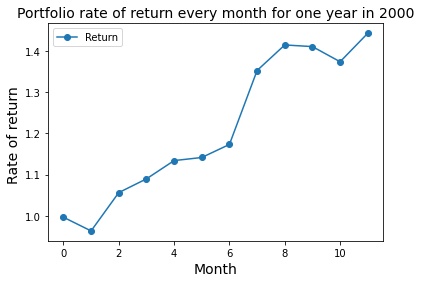

In [22]:
df_4.plot(y = 'Return', use_index = True, marker='o')
plt.title('Portfolio rate of return every month for one year in 2000', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Rate of return ', fontsize=14)

In [23]:
list(complete_stock_data.columns.values)

['AA US Equity',
 'AAPL US Equity',
 'ABMD US Equity',
 'ABT US Equity',
 'ADBE US Equity',
 'ADI US Equity',
 'ADM US Equity',
 'ADP US Equity',
 'ADSK US Equity',
 'AEP US Equity',
 'AES US Equity',
 'AFL US Equity',
 'AGN US Equity',
 'AIG US Equity',
 'AJG US Equity',
 'ALK US Equity',
 'ALL US Equity',
 'AMAT US Equity',
 'AMD US Equity',
 'AMGN US Equity',
 'AN US Equity',
 'ANDV US Equity',
 'AON US Equity',
 'AOS US Equity',
 'APA US Equity',
 'APC US Equity',
 'APD US Equity',
 'ASH US Equity',
 'ATGE US Equity',
 'AVP US Equity',
 'AVY US Equity',
 'AXP US Equity',
 'AZO US Equity',
 'BA US Equity',
 'BAC US Equity',
 'BAX US Equity',
 'BBBY US Equity',
 'BBT US Equity',
 'BBY US Equity',
 'BC US Equity',
 'BCO US Equity',
 'BDX US Equity',
 'BEN US Equity',
 'BF/B US Equity',
 'BGG US Equity',
 'BHGE US Equity',
 'BIG US Equity',
 'BIIB US Equity',
 'BK US Equity',
 'BLL US Equity',
 'BMS US Equity',
 'BMY US Equity',
 'BSET US Equity',
 'BSX US Equity',
 'BWA US Equity',
 '

In [24]:
import random
random.choices(list(complete_stock_data.columns.values), k = 10)

['ETN US Equity',
 'ORCL US Equity',
 'JBHT US Equity',
 'RAD US Equity',
 'SLB US Equity',
 'SPXC US Equity',
 'BA US Equity',
 'TROW US Equity',
 'AOS US Equity',
 'PH US Equity']

In [25]:
df_5 = pd.DataFrame(columns = ['Return'])
for i in range(12):
    df_5.loc[i] = weighted_return(2001, i+1)
years_2 = df_2.append(df_5, sort =  False).reset_index()

Text(0, 0.5, 'Rate of return ')

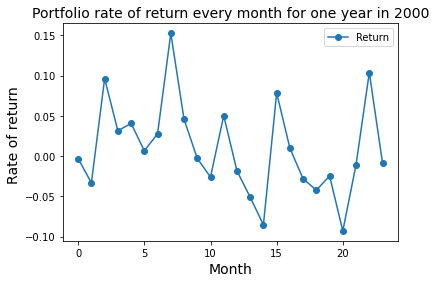

In [26]:
years_2.plot(y = 'Return', use_index = True, marker='o')
plt.title('Portfolio rate of return every month for one year in 2000', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Rate of return ', fontsize=14)

Text(0, 0.5, 'Rate of return ')

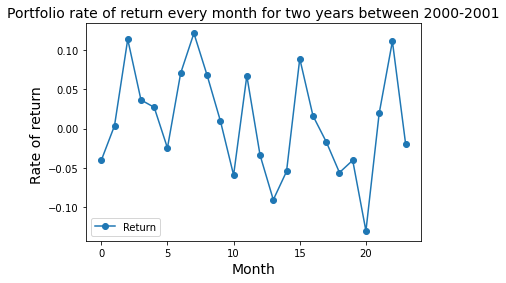

In [27]:
year_2000 = pd.DataFrame(columns = ['Return'])
for i in range(12):
    year_2000.loc[i] = weighted_return(2000, i+1)
year_2001 = pd.DataFrame(columns = ['Return'])
for i in range(12):
    year_2001.loc[i] = weighted_return(2001, i+1)
year_2000_and_2001 = year_2000.append(year_2001, sort =  False).reset_index()
year_2000_and_2001.plot(y = 'Return', use_index = True, marker='o')
plt.title('Portfolio rate of return every month for two years between 2000-2001', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Rate of return ', fontsize=14)

In [ ]:
company_for_example = ['MO US Equity',
 'GLW US Equity',
 'DDS US Equity',
 'BBBY US Equity',
 'UIS US Equity',
 'EQR US Equity',
 'AFL US Equity',
 'ALK US Equity',
 'IP US Equity',
 'PPL US Equity']

<AxesSubplot:>

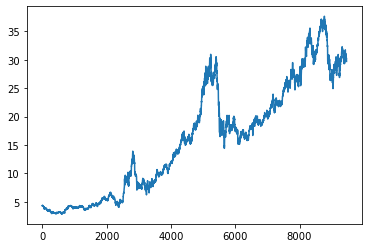

In [6]:
stock_data_raw["PPL US Equity"].plot()

<AxesSubplot:xlabel='Date'>

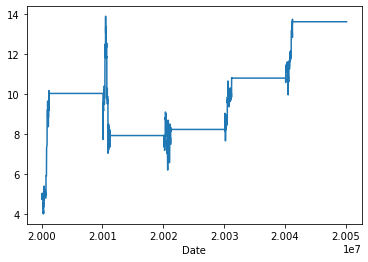

In [20]:
thousand = complete_stock_data.loc[20000101:20050101, :]
thousand["PPL US Equity"].plot()

<AxesSubplot:xlabel='Date'>

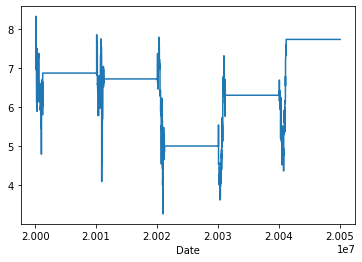

In [21]:
thousand[" US Equity"].plot()